In [1]:
import pandas as pd
import datetime
import os
import zipfile
import glob
import requests
import shutil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

In [2]:
def download_datasets(urls, start_year, end_year):
    # for year in range(start_year, end_year + 1):
    for download_url in urls:
        # download_url = url.replace('2023', str(year))
        print(f'downloading {download_url}')
        response = requests.get(download_url)
        if response.status_code == 200:
            file_name = download_url.split('/')[-1]
            with open(file_name, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {file_name}")
        else:
            print(f"Failed to download {download_url}")
                
def load_data_to_df(projects):
    current_year = datetime.datetime.now().year
    all_data = []
    for project in projects:
        for year in range(2023, current_year + 1):
            archive_name = f"{year}_{project}.zip"
            # Assuming the archive is downloaded in the current working directory
            with zipfile.ZipFile(archive_name, 'r') as z:
                z.extractall("temp_data")
                for filename in glob.glob(f"temp_data/data/transcriptions/{project}/*.txt"):
                    """with open(filename, 'r', encoding='utf-8') as file:
                        text = file.read()
                        # Extract date and time from the filename
                        basename = os.path.basename(filename)
                        datetime_str = basename.split('.')[0]  # Remove the file extension
                        datetime_str = datetime_str.replace('_', ' ')  # Replace the underscore with a space
                        all_data.append({"project": project, "date": datetime_str, "text": text})"""
                    with open(filename, 'r', encoding='utf-8') as file:
                        text = file.read()
                        # Extract date and time from the filename
                        basename = os.path.basename(filename)
                        datetime_str = basename.split('.')[0]  # Remove the file extension

                        # Split into date and time components
                        date_part, time_part = datetime_str.split('_')
                        # Format time part correctly (replace '-' with ':')
                        time_part_formatted = time_part.replace('-', ':')

                        # Combine date and time with a space
                        datetime_str_formatted = f"{date_part} {time_part_formatted}"

                        all_data.append({"project": project, "date": datetime_str_formatted, "text": text})

                # Cleanup extracted files
                shutil.rmtree(f"temp_data/data/transcriptions/{project}")
            # Cleanup the remaining temporary directory
            shutil.rmtree("temp_data")
    
    return pd.DataFrame(all_data)

def search_text_in_dataset(df, project=None, search_text=None, date_start=None, date_end=None):
    # Filter by project if specified
    if project:
        df = df[df['project'] == project]

    # Assuming the 'date' field includes time information and is in a standard format like 'yyyy-mm-dd hh:mm:ss'
    df['date'] = pd.to_datetime(df['date'])

    # Filter by date range if specified
    if date_start:
        df = df[df['date'] >= pd.to_datetime(date_start)]
    if date_end:
        df = df[df['date'] <= pd.to_datetime(date_end)]

    # Search for text and count occurrences (case-insensitive)
    if search_text:
        search_text_lower = search_text.lower()  # Convert search text to lowercase
        df['count_of_references'] = df['text'].apply(lambda x: x.lower().count(search_text_lower))
    else:
        df['count_of_references'] = 0

    # Returning the project, date, count of references, and text
    return df[['project', 'date', 'count_of_references', 'text']]

def plot_references_timeline(df):
    # Ensure 'date' is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Prepare the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['date'], df['count_of_references'], alpha=0.7)

    # Formatting the date on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.title('Timeline of References')
    plt.xlabel('Date and Time')
    plt.ylabel('Count of References')

    plt.show()
    
def extract_sentences_with_reference(df, reference):
    result = []
    for index, row in df.iterrows():
        # Split text into sentences
        sentences = re.split(r'[.?!]', row['text'])

        # Check each sentence for the reference
        for sentence in sentences:
            if reference.lower() in sentence.lower():
                result.append(f"{row['date']} {row['project']} {sentence.strip()}.")
    return result

In [3]:
current_year = datetime.datetime.now().year
projects = ['ORT', 'belarusone', 'oneplusone', 'russiaone']
urls = []
for year in range(2023, current_year + 1):
    for project in projects:
        urls.append(f"https://storage.googleapis.com/rtlm/{year}_{project}.zip")
urls

['https://storage.googleapis.com/rtlm/2023_ORT.zip',
 'https://storage.googleapis.com/rtlm/2023_belarusone.zip',
 'https://storage.googleapis.com/rtlm/2023_oneplusone.zip',
 'https://storage.googleapis.com/rtlm/2023_russiaone.zip']

In [4]:
download_datasets(urls, 2023, current_year)

downloading https://storage.googleapis.com/rtlm/2023_ORT.zip
Downloaded 2023_ORT.zip
downloading https://storage.googleapis.com/rtlm/2023_belarusone.zip
Downloaded 2023_belarusone.zip
downloading https://storage.googleapis.com/rtlm/2023_oneplusone.zip
Downloaded 2023_oneplusone.zip
downloading https://storage.googleapis.com/rtlm/2023_russiaone.zip
Downloaded 2023_russiaone.zip


In [5]:
projects = [url.split('/')[-1].split('_')[1].split('.')[0] for url in urls]

# Create the DataFrame
df = load_data_to_df(projects)

# Display the DataFrame
print(df.head(2))

  project                 date  \
0     ORT  2023-11-08 20:24:32   
1     ORT  2023-11-27 16:22:12   
2     ORT  2023-11-22 20:06:33   
3     ORT  2023-11-19 21:35:02   
4     ORT  2023-11-12 14:43:32   

                                                text  
0   Казаться от самостоятельной линии во внешних ...  
1   Подарок. Купи Infinix со связи и получи второ...  
2                       Субтитры создавал DimaTorzok  
3   Майдана из-за сцены. Они нарушают закон, надо...  
4   Способности творить. Всё, что лучше в нём, чт...  


140


/tmp/ipykernel_251477/287858076.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


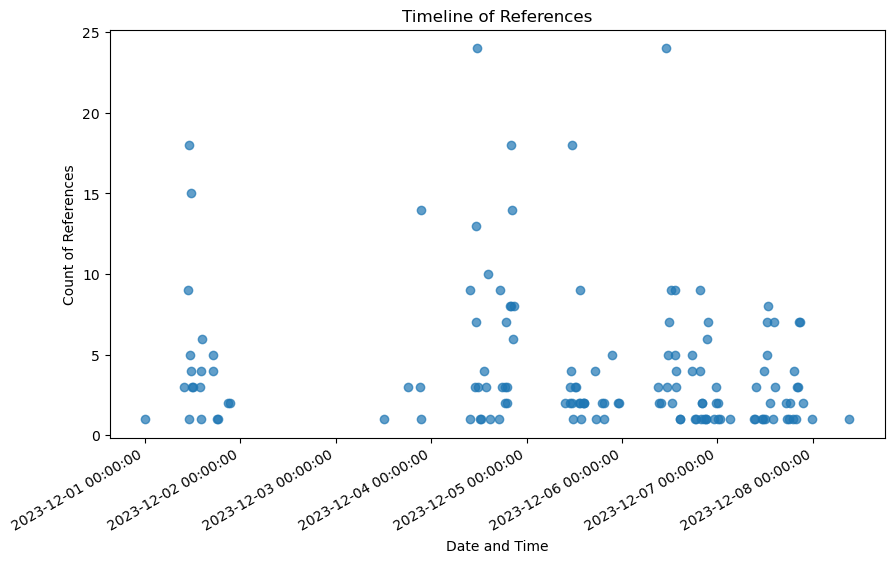

In [6]:
result_df = search_text_in_dataset(df, project='ORT', search_text='зеленск', date_start='2023-12-01', date_end='2023-12-31')
result_df = result_df[result_df.count_of_references>0]
print(len(result_df))
plot_references_timeline(result_df)

In [7]:
result_df.head(2)

,project,date,count_of_references,text
29,ORT,2023-12-04 20:51:18,8,"такой занюханной и всё. Вы говорите, она вози..."
64,ORT,2023-12-04 19:11:12,2,Пыше. Мы это прочитаем как ослабление противн...


In [8]:
sentences = extract_sentences_with_reference(result_df, 'зеленск')
for sentence in sentences:
    print(sentence, '\n')

2023-12-04 20:51:18 ORT Там он, говоря, что он Британии в свое время присягнул, когда пришел вместе с Зеленским. 

2023-12-04 20:51:18 ORT Только в указе Зеленского написано, что он кто-то. 

2023-12-04 20:51:18 ORT Но в Конституции написано, что Зеленский будет создавать массу консультативных органов, массу, для того, чтобы они ему помогали работать. 

2023-12-04 20:51:18 ORT У него около 20 советников, а у Зеленского сколько. 

2023-12-04 20:51:18 ORT Помните историю с Еленой Зеленской. 

2023-12-04 20:51:18 ORT Кстати, Елена Зеленская один из клиентов. 

2023-12-04 20:51:18 ORT это будет голова Зеленского или голова Ермака, это большой вопрос. 

2023-12-04 20:51:18 ORT Даже не Зеленский, а конкретно Ермак. 

2023-12-04 19:11:12 ORT Что будет делать Зеленский. 

2023-12-04 19:11:12 ORT Там Зеленский, Залужный, у нас раскол и так далее. 

2023-12-06 17:31:14 ORT наверное примерно вот сколько они обещали снарядов столько они дали слов и буковок украинским политиком в виде всяких обещан

#### Next, we can summarize and answer some questions using one of modern LLM
Это упоминания Зеленского на канале ОРТ.

Суммаризируй пожалуйста что о нем говорят, какие основные тезисы и какие противоречия. Что хорошего и что плохого.

#### claude.ai sample:

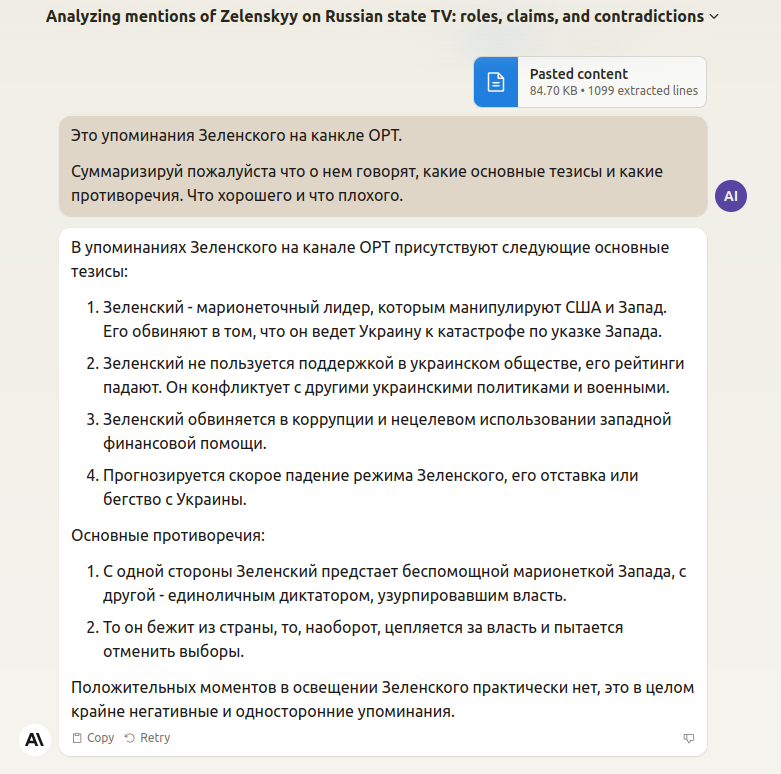